# Pràctica 4: Similitud de Text Semàntic (STS) per al Català

**Objectiu**: Entrenar i avaluar models de Similitud de Text Semàntic per al català utilitzant diferents tècniques d'embeddings i arquitectures de models.

## Estructura de la Pràctica:
1. **Preparació d'Embeddings** - Carregar i truncar embeddings Word2Vec
2. **Models Baseline** - Similitud cosinus simple
3. **Model 1**: Embeddings Agregats - Vectors de frase concatenats
4. **Model 2**: Seqüència d'Embeddings - Amb mecanisme d'atenció
5. **Experimentació Avançada** - Comparació amb altres embeddings
6. **Anàlisi de Resultats** - Correlació de Pearson i avaluació

In [59]:
# Imports necessaris
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional, Dict, Union
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')
# Configuració de GPU (opcional)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: []


## 1. Carrega del Dataset STS-ca

In [60]:
from datasets import load_dataset

# Carregar el dataset STS-ca
print("Carregant dataset STS-ca...")
train_data = load_dataset("projecte-aina/sts-ca", split="train")
test_data = load_dataset("projecte-aina/sts-ca", split="test") 
val_data = load_dataset("projecte-aina/sts-ca", split="validation")

# Convertir a DataFrame per facilitar la manipulació
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Label range: {train_df['label'].min():.2f} - {train_df['label'].max():.2f}")

# Mostrar alguns exemples
print("\nExemples del dataset:")
for i in range(3):
    print(f"Frase 1: {train_df.iloc[i]['sentence_1']}")
    print(f"Frase 2: {train_df.iloc[i]['sentence_2']}")
    print(f"Similitud: {train_df.iloc[i]['label']}")
    print("-" * 50)

Carregant dataset STS-ca...
Train samples: 2073
Test samples: 500
Validation samples: 500
Label range: 0.00 - 5.00

Exemples del dataset:
Frase 1: Atorga per primer cop les mencions Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència Universitària
Frase 2: Creen la menció M. Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència universitària
Similitud: 3.5
--------------------------------------------------
Frase 1: Finalment, afegiu-hi els bolets que haureu saltat en una paella amb oli i deixeu-ho coure tot junt durant 5 minuts.
Frase 2: Finalment, poseu-hi les minipastanagues tallades a dauets, els pèsols, rectifiqueu-ho de sal i deixeu-ho coure tot junt durant un parell de minuts més.
Similitud: 1.25
--------------------------------------------------
Frase 1: El TC suspèn el pla d'acció exterior i de relacions amb la UE de la Generalitat
Frase 2: El Constitucional manté la suspensió del pla estratègic d'acció exterior i relacions amb la UE
Similitu

## 2. Carrega i Preparació dels Word Embeddings

In [61]:
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

# Carregar el model Word2Vec pre-entrenat
WV_MODEL_PATH = '../cc.ca.300.vec'

print("Carregant model Word2Vec...")

kv_model = KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
print(f"Model carregat amb èxit. Vocabulari: {len(kv_model.key_to_index)} paraules")
print(f"Dimensió dels vectors: {kv_model.vector_size}")

Carregant model Word2Vec...
Model carregat amb èxit. Vocabulari: 2000000 paraules
Dimensió dels vectors: 300


In [62]:
# Exemple d'ús
test_words = ["casa", "gat", "aigua", "carbassot"]
for word in test_words:
    if word in kv_model:
        print(f"Vector per '{word}': {kv_model[word][:5]}... (dim={kv_model.vector_size})")
    else:
        print(f"Paraula '{word}' no trobada al vocabulari")

Vector per 'casa': [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (dim=300)
Vector per 'gat': [ 0.0061  0.0675 -0.0248 -0.0541 -0.0722]... (dim=300)
Vector per 'aigua': [-0.0031  0.0427 -0.0397  0.0366 -0.0551]... (dim=300)
Vector per 'carbassot': [-0.0029 -0.0462 -0.0255 -0.0149 -0.0358]... (dim=300)


In [63]:
# Funció per truncar embeddings a dimensions més petites
def create_truncated_embeddings(kv_model, dimensions: List[int]) -> Dict[int, Dict[str, np.ndarray]]:
    """
    Crea versions truncades dels embeddings amb diferents dimensions
    """
    if kv_model is None:
        return {}
    
    truncated_models = {}
    
    for dim in dimensions:
        print(f"Creant embeddings de {dim} dimensions...")
        truncated_dict = {}
        
        for word in kv_model.key_to_index:
            original_vector = kv_model[word]
            truncated_vector = original_vector[:dim]
            truncated_dict[word] = truncated_vector
            
        truncated_models[dim] = truncated_dict
        print(f"  Completat: {len(truncated_dict)} paraules truncades a {dim}D")
    
    return truncated_models

# Crear versions truncades
dimensions = [50, 100, 150, 300]  # Incloem 300 per consistència
if kv_model is not None:
    truncated_embeddings = create_truncated_embeddings(kv_model, dimensions)
    print(f"\nVersions d'embeddings disponibles: {list(truncated_embeddings.keys())}")
else:
    truncated_embeddings = {}


Creant embeddings de 50 dimensions...
  Completat: 2000000 paraules truncades a 50D
Creant embeddings de 100 dimensions...
  Completat: 2000000 paraules truncades a 100D
Creant embeddings de 150 dimensions...
  Completat: 2000000 paraules truncades a 150D
Creant embeddings de 300 dimensions...
  Completat: 2000000 paraules truncades a 300D

Versions d'embeddings disponibles: [50, 100, 150, 300]


In [64]:
print("Model truncat a 50 dimensions:")
print(truncated_embeddings[50]['casa'])
print("Model truncat a 100 dimensions:")
print(truncated_embeddings[100]['casa'])

Model truncat a 50 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007]
Model truncat a 100 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007  0.0245  0.0052  0.0003  0.0288
  0.0476  0.0015  0.1529 -0.0132  0.025  -0.0274  0.0314  0.0709 -0.0816
 -0.0661  0.0462  0.007

## 3. Funcions d'Utilitat per Processament de Text

In [65]:
def preprocess_sentence(sentence: str) -> List[str]:
    """
    Preprocessa una frase: tokenització simple
    """
    return simple_preprocess(sentence.lower())

def get_sentence_embedding_simple(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                                vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana dels embeddings de les paraules
    """
    words = preprocess_sentence(sentence)
    vectors = []
    
    for word in words:
        if word in embeddings_dict:
            vectors.append(embeddings_dict[word])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

def get_sentence_embedding_tfidf(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                               tfidf_vectorizer: TfidfVectorizer, 
                               feature_names: List[str], vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana ponderada amb TF-IDF
    """
    words = preprocess_sentence(sentence)
    
    # Calcular TF-IDF per a la frase
    tfidf_vector = tfidf_vectorizer.transform([' '.join(words)])
    tfidf_scores = tfidf_vector.toarray()[0]
    
    weighted_vectors = []
    weights = []
    
    for word in words:
        if word in embeddings_dict and word in feature_names:
            word_idx = feature_names.index(word)
            weight = tfidf_scores[word_idx]
            if weight > 0:
                weighted_vectors.append(embeddings_dict[word] * weight)
                weights.append(weight)
    
    if weighted_vectors and sum(weights) > 0:
        return np.sum(weighted_vectors, axis=0) / sum(weights)
    else:
        return np.zeros(vector_size)

# Preprocessar totes les frases del dataset
print("Preprocessant frases del dataset...")
all_sentences = (train_df['sentence_1'].tolist() + train_df['sentence_2'].tolist() + 
                test_df['sentence_1'].tolist() + test_df['sentence_2'].tolist() + 
                val_df['sentence_1'].tolist() + val_df['sentence_2'].tolist())

# Crear vocabulari per TF-IDF
all_words = []
for sentence in all_sentences:
    all_words.extend(preprocess_sentence(sentence))

print(f"Total de frases processades: {len(all_sentences)}")
print(f"Vocabulari únic: {len(set(all_words))} paraules")

Preprocessant frases del dataset...
Total de frases processades: 6146
Vocabulari únic: 13125 paraules


## 4. Baseline: Similitud Cosinus

In [66]:
def evaluate_cosine_baseline(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                           vector_size: int, use_tfidf: bool = False, 
                           tfidf_vectorizer=None, feature_names=None) -> Dict[str, float]:
    """
    Avalua el baseline de similitud cosinus
    """
    similarities = []
    true_scores = df['label'].values
    
    for _, row in df.iterrows():
        sent1, sent2 = row['sentence_1'], row['sentence_2']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        # Calcular similitud cosinus
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        
        # Escalar de [-1,1] a [0,5] per coincidir amb les etiquetes
        sim_scaled = (sim + 1) * 2.5
        similarities.append(sim_scaled)
    
    # Calcular mètriques
    similarities = np.array(similarities)
    pearson_corr, _ = pearsonr(true_scores, similarities)
    mse = mean_squared_error(true_scores, similarities)
    mae = mean_absolute_error(true_scores, similarities)
    
    return {
        'pearson': pearson_corr,
        'mse': mse,
        'mae': mae,
        'predictions': similarities
    }

# Preparar TF-IDF
if kv_model is not None:
    print("Preparant TF-IDF vectorizer...")
    corpus_for_tfidf = [' '.join(preprocess_sentence(sent)) for sent in all_sentences]
    tfidf_vectorizer = TfidfVectorizer(max_features=10000, lowercase=True)
    tfidf_vectorizer.fit(corpus_for_tfidf)
    feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
    
    print("Avaluant baselines de similitud cosinus...")
    
    # Avaluar per diferents dimensions
    baseline_results = {}
    results_list = []
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            # Mitjana simple
            results_simple = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=False
            )

            # Mitjana ponderada TF-IDF
            results_tfidf = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=True,
                tfidf_vectorizer=tfidf_vectorizer, feature_names=feature_names
            )

            baseline_results[dim] = {
                'simple': results_simple,
                'tfidf': results_tfidf
            }

            results_list.append({
                'Model': 'Baseline Cosinus Simple',
                'Dimensions': f'{dim}D',
                'Pearson': results_simple['pearson'],
                'MSE': results_simple['mse'],
                'MAE': results_simple['mae']
            })
            results_list.append({
                'Model': 'Baseline Cosinus TF-IDF',
                'Dimensions': f'{dim}D',
                'Pearson': results_tfidf['pearson'],
                'MSE': results_tfidf['mse'],
                'MAE': results_tfidf['mae']
            })

Preparant TF-IDF vectorizer...
Avaluant baselines de similitud cosinus...


In [67]:
print("\n=== COMPARACIÓ MODELS BASELINE COSINUS ===")
df_baseline_results = pd.DataFrame(results_list)
display(df_baseline_results.style.hide(axis="index"))


=== COMPARACIÓ MODELS BASELINE COSINUS ===


Model,Dimensions,Pearson,MSE,MAE
Baseline Cosinus Simple,50D,0.175156,6.156660,2.335413
Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
Baseline Cosinus Simple,100D,0.213043,5.936303,2.290625
Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081


## 5. Model 1: Regressió amb Embeddings Agregats

In [68]:
def build_model_aggregated(embedding_dim: int, hidden_size: int = 128, 
                         dropout_rate: float = 0.3) -> tf.keras.Model:
    """
    Construeix el model de regressió amb embeddings agregats
    """
    input_1 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_2")
    
    # Concatenar els dos vectors
    concatenated = tf.keras.layers.Concatenate(axis=-1)([input_1, input_2])
    
    # Capes de processament
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(hidden_size // 2, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Capa de sortida (regressió)
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

def prepare_aggregated_data(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                          vector_size: int, use_tfidf: bool = False,
                          tfidf_vectorizer=None, feature_names=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepara les dades per al model d'embeddings agregats
    """
    X1, X2, Y = [], [], []
    
    for _, row in df.iterrows():
        sent1, sent2, label = row['sentence_1'], row['sentence_2'], row['label']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        X1.append(vec1)
        X2.append(vec2)
        Y.append(label)
    
    return np.array(X1), np.array(X2), np.array(Y)

# Entrenar models agregats per diferents dimensions
if kv_model is not None:
    aggregated_results = {}
    
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            print(f"\n=== Entrenant Model Agregat {dim}D ===")
            
            # Preparar dades
            X1_train, X2_train, Y_train = prepare_aggregated_data(
                train_df, truncated_embeddings[dim], dim
            )
            X1_val, X2_val, Y_val = prepare_aggregated_data(
                val_df, truncated_embeddings[dim], dim
            )
            
            print(f"Forma de les dades: X1_train={X1_train.shape}, Y_train={Y_train.shape}")
            
            # Construir i entrenar model
            model = build_model_aggregated(embedding_dim=dim)
            
            # Callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
            )
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
            )
            
            # Entrenament
            history = model.fit(
                [X1_train, X2_train], Y_train,
                validation_data=([X1_val, X2_val], Y_val),
                epochs=50,
                batch_size=32,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            # Avaluació
            Y_pred = model.predict([X1_val, X2_val]).flatten()
            pearson_corr, _ = pearsonr(Y_val, Y_pred)
            mse = mean_squared_error(Y_val, Y_pred)
            mae = mean_absolute_error(Y_val, Y_pred)
            
            aggregated_results[dim] = {
                'model': model,
                'history': history,
                'pearson': pearson_corr,
                'mse': mse,
                'mae': mae,
                'predictions': Y_pred
            }
            
            print(f"Resultats {dim}D - Pearson: {pearson_corr:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")


=== Entrenant Model Agregat 50D ===
Forma de les dades: X1_train=(2073, 50), Y_train=(2073,)
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.8389 - mae: 2.3683 - root_mean_squared_error: 2.7657 - val_loss: 3.6616 - val_mae: 1.7327 - val_root_mean_squared_error: 1.9135 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2380 - mae: 1.1826 - root_mean_squared_error: 1.4958 - val_loss: 1.7688 - val_mae: 1.0999 - val_root_mean_squared_error: 1.3300 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9846 - mae: 1.0967 - root_mean_squared_error: 1.4067 - val_loss: 0.9105 - val_mae: 0.7508 - val_root_mean_squared_error: 0.9542 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5872 - mae: 0.9987 - root_mean_squared_error: 1.2591 - val_loss: 0.7415 - val_mae: 0.6649 - val_root_mean_squared_error: 0.8611 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

In [69]:
print("\n=== COMPARACIÓ MODELS AGREGATS ===")
# Crear un DataFrame amb els resultats dels models agregats
aggr_data = []
for dim in [50, 100, 150, 300]:
    if dim in aggregated_results:
        aggr_data.append({
            'Model': 'Model Agregat',
            'Dimensions': f'{dim}D',
            'Pearson': aggregated_results[dim]['pearson'],
            'MSE': aggregated_results[dim]['mse'],
            'MAE': aggregated_results[dim]['mae']
        })

df_aggregated = pd.DataFrame(aggr_data)
df_results = pd.concat([df_baseline_results, df_aggregated], ignore_index=True)
display(df_aggregated.style.hide(axis="index"))


=== COMPARACIÓ MODELS AGREGATS ===


Model,Dimensions,Pearson,MSE,MAE
Model Agregat,50D,0.079203,0.741502,0.664918
Model Agregat,100D,0.172731,0.712690,0.651149
Model Agregat,150D,0.146563,0.718812,0.651244
Model Agregat,300D,0.199055,0.700723,0.643298


## 6. Model 2: Seqüència d'Embeddings amb Atenció

In [70]:
import tensorflow as tf
import numpy as np
from typing import Optional

class SimpleAttention(tf.keras.layers.Layer):
    """
    Capa d'atenció simple per agregar seqüències d'embeddings
    """
    def __init__(self, units: int, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
        self.dropout_s1 = tf.keras.layers.Dropout(0.3)
        self.dropout_s2 = tf.keras.layers.Dropout(0.2)
        self.W_s1 = tf.keras.layers.Dense(units, activation='tanh', use_bias=True, name="attention_transform")
        # Dense layer to compute attention scores (context vector)
        self.W_s2 = tf.keras.layers.Dense(1, use_bias=False, name="attention_scorer")
        self.supports_masking = True  # Declare that this layer supports masking

    def call(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        # mask shape: (batch_size, sequence_length) boolean tensor

        # Attention hidden states
        hidden_states = self.dropout_s1(self.W_s1(inputs))

        # Compute attention scores
        scores = self.dropout_s2(self.W_s2(hidden_states))

        if mask is not None:
            # Apply the mask to the scores before softmax
            expanded_mask = tf.expand_dims(tf.cast(mask, dtype=tf.float32), axis=-1)
            # Add a large negative number to masked (padded) scores
            scores += (1.0 - expanded_mask) * -1e9

        # Compute attention weights
        attention_weights = tf.nn.softmax(scores, axis=1)

        # Compute the context vector (weighted sum of input embeddings)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        return context_vector

    def get_config(self) -> dict:
        config = super(SimpleAttention, self).get_config()
        config.update({"units": self.units})
        return config

    def compute_mask(self, inputs: tf.Tensor, mask: Optional[tf.Tensor] = None) -> Optional[tf.Tensor]:
        return None


def build_model_sequence(vocab_size: int = 1000, 
                        embedding_dim: int = 300,
                        sequence_length: int = 32,
                        learning_rate: float = 0.001,
                        trainable_embeddings: bool = False,
                        pretrained_weights: Optional[np.ndarray] = None,
                        use_attention: bool = True,
                        attention_units: int = 4) -> tf.keras.Model:
    """
    Model de seqüència millorat basat en build_and_compile_model_2
    Incorpora similitud cosinus i escalat adequat per STS
    """
    input_1 = tf.keras.Input((sequence_length,), dtype=tf.int32, name="input_1")
    input_2 = tf.keras.Input((sequence_length,), dtype=tf.int32, name="input_2")

    # Determine effective embedding parameters
    if pretrained_weights is not None:
        effective_dictionary_size = pretrained_weights.shape[0]
        effective_embedding_size = pretrained_weights.shape[1]
        embedding_initializer = tf.keras.initializers.Constant(pretrained_weights)
        is_embedding_trainable = trainable_embeddings
        embedding_layer_name = "embedding_pretrained"
    else:
        effective_dictionary_size = vocab_size
        effective_embedding_size = embedding_dim
        embedding_initializer = 'uniform'
        is_embedding_trainable = True
        embedding_layer_name = "embedding"

    # Shared Embedding Layer
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=effective_dictionary_size,
        output_dim=effective_embedding_size,
        input_length=sequence_length,
        mask_zero=True,
        embeddings_initializer=embedding_initializer,
        trainable=is_embedding_trainable,
        name=embedding_layer_name
    )

    # Apply embedding layer to both inputs
    embedded_1 = embedding_layer(input_1)  # Shape: (batch_size, sequence_length, effective_embedding_size)
    embedded_2 = embedding_layer(input_2)  # Shape: (batch_size, sequence_length, effective_embedding_size)

    # Shared pooling/attention layer
    if use_attention:
        # Use attention mechanism
        sentence_pooling_layer = SimpleAttention(units=attention_units, name="sentence_attention")
    else:
        # Use simple global average pooling
        sentence_pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="sentence_attention_layer")

    # Apply pooling/attention to get sentence vectors
    sentence_vector_1 = sentence_pooling_layer(embedded_1)
    sentence_vector_2 = sentence_pooling_layer(embedded_2)

    # Projection layer
    first_projection_layer = tf.keras.layers.Dense(
        effective_embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.2, name="projection_dropout")
    projected_1 = dropout(first_projection_layer(sentence_vector_1))
    projected_2 = dropout(first_projection_layer(sentence_vector_2))

    # Normalize the projected vectors (L2 normalization)
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2)

    # Compute Cosine Similarity
    similarity_score = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="cosine_similarity"
    )([normalized_1, normalized_2])

    # Scale similarity from [-1, 1] to [0, 1]
    output_layer = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling"
    )(similarity_score)

    # Define the Keras Model
    model = tf.keras.Model(
        inputs=[input_1, input_2],
        outputs=output_layer,
        name="sequence_similarity_attention_model"
    )

    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae'],
    )

    return model

In [71]:
from typing import List, Dict, Tuple
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Preparació de dades per al model de seqüències
def create_vocabulary_mapping(sentences: List[str], max_vocab_size: int = 10000) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Crea un mapatge de vocabulari paraula->índex i índex->paraula
    """
    word_counts = {}
    for sentence in sentences:
        words = preprocess_sentence(sentence)
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
    
    # Ordenar per freqüència i prendre les més comunes
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Reservar índexs especials: 0=PAD, 1=UNK
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    idx_to_word = {0: "<PAD>", 1: "<UNK>"}
    
    for word, count in sorted_words[:max_vocab_size-2]:  # -2 per PAD i UNK
        idx = len(word_to_idx)
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    
    return word_to_idx, idx_to_word

def sentence_to_sequence(sentence: str, word_to_idx: Dict[str, int], 
                        max_length: int = 32) -> np.ndarray:
    """
    Converteix una frase a seqüència d'índexs
    """
    words = preprocess_sentence(sentence)
    sequence = []
    
    for word in words:
        if word in word_to_idx:
            sequence.append(word_to_idx[word])
        else:
            sequence.append(word_to_idx["<UNK>"])
    
    # Padding o truncament
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence.extend([word_to_idx["<PAD>"]] * (max_length - len(sequence)))
    
    return np.array(sequence)

def create_pretrained_embedding_matrix(word_to_idx: Dict[str, int], 
                                     embeddings_dict: Dict[str, np.ndarray],
                                     embedding_dim: int) -> np.ndarray:
    """
    Crea una matriu d'embeddings pre-entrenats
    """
    vocab_size = len(word_to_idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in embeddings_dict:
            embedding_matrix[idx] = embeddings_dict[word]
        # Les paraules no trobades mantenen vectors zero
    
    return embedding_matrix

In [72]:
print("Preparant dades per al model de seqüències...")

# Crear vocabulari
word_to_idx, idx_to_word = create_vocabulary_mapping(all_sentences, max_vocab_size=10000)
vocab_size = len(word_to_idx)
sequence_length = 32

print(f"Vocabulari creat: {vocab_size} paraules")
print(f"Longitud de seqüència: {sequence_length}")

# Convertir dades per a models de seqüència
def prepare_sequence_data(df):
    X1_seq, X2_seq, Y_seq = [], [], []
    for _, row in df.iterrows():
        seq1 = sentence_to_sequence(row['sentence_1'], word_to_idx, sequence_length)
        seq2 = sentence_to_sequence(row['sentence_2'], word_to_idx, sequence_length)
        X1_seq.append(seq1)
        X2_seq.append(seq2)
        Y_seq.append(row['label'])
    return np.array(X1_seq), np.array(X2_seq), np.array(Y_seq)

X1_train_seq, X2_train_seq, Y_train_seq = prepare_sequence_data(train_df)
X1_val_seq, X2_val_seq, Y_val_seq = prepare_sequence_data(val_df)

print(f"Dades de seqüència preparades: {X1_train_seq.shape}")

# Entrenar models de seqüència per diferents dimensions
sequence_results = {}

for embedding_dim in [50, 100, 150, 300]:
    if embedding_dim in truncated_embeddings:
        print(f"\n=== MODELS DE SEQÜÈNCIA {embedding_dim}D ===")
        
        # Preparar matriu d'embeddings pre-entrenats
        pretrained_matrix = create_pretrained_embedding_matrix(
            word_to_idx, truncated_embeddings[embedding_dim], embedding_dim
        )
        
        # Model 1: Embeddings pre-entrenats (frozen)
        print(f"Entrenant model amb embeddings pre-entrenats frozen ({embedding_dim}D)...")
        model_seq_frozen = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=False
        )
        
        history_frozen = model_seq_frozen.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_frozen = model_seq_frozen.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_frozen, _ = pearsonr(Y_val_seq, Y_pred_frozen)
        mse_frozen = mean_squared_error(Y_val_seq, Y_pred_frozen)
        mae_frozen = mean_absolute_error(Y_val_seq, Y_pred_frozen)
        
        print(f"  Frozen - Pearson: {pearson_frozen:.3f}, MSE: {mse_frozen:.3f}, MAE: {mae_frozen:.3f}")
        
        # Model 2: Embeddings pre-entrenats (trainable)
        print(f"Entrenant model amb embeddings pre-entrenats trainable ({embedding_dim}D)...")
        model_seq_trainable = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=True
        )
        
        history_trainable = model_seq_trainable.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_trainable = model_seq_trainable.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_trainable, _ = pearsonr(Y_val_seq, Y_pred_trainable)
        mse_trainable = mean_squared_error(Y_val_seq, Y_pred_trainable)
        mae_trainable = mean_absolute_error(Y_val_seq, Y_pred_trainable)
        
        print(f"  Trainable - Pearson: {pearson_trainable:.3f}, MSE: {mse_trainable:.3f}, MAE: {mae_trainable:.3f}")
        
        # Model 3: Embeddings aleatoris
        
        print(f"Entrenant model amb embeddings aleatoris ({embedding_dim}D)...")
        model_seq_random = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=None,
            trainable_embeddings=True
        )
        
        history_random = model_seq_random.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        Y_pred_random = model_seq_random.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_random, _ = pearsonr(Y_val_seq, Y_pred_random)
        mse_random = mean_squared_error(Y_val_seq, Y_pred_random)
        mae_random = mean_absolute_error(Y_val_seq, Y_pred_random)
        
        print(f"  Random - Pearson: {pearson_random:.3f}, MSE: {mse_random:.3f}, MAE: {mae_random:.3f}")
        
        sequence_results[embedding_dim] = {
            'frozen': {'model': model_seq_frozen, 'pearson': pearson_frozen, 'mse': mse_frozen, 'mae': mae_frozen},
            'trainable': {'model': model_seq_trainable, 'pearson': pearson_trainable, 'mse': mse_trainable, 'mae': mae_trainable},
            'random': {'model': model_seq_random, 'pearson': pearson_random, 'mse': mse_random, 'mae': mae_random}
        }
    else:
        sequence_results[embedding_dim] = {
            'frozen': {'model': model_seq_frozen, 'pearson': pearson_frozen, 'mse': mse_frozen, 'mae': mae_frozen},
            'trainable': {'model': model_seq_trainable, 'pearson': pearson_trainable, 'mse': mse_trainable, 'mae': mae_trainable}
        }

Preparant dades per al model de seqüències...
Vocabulari creat: 10000 paraules
Longitud de seqüència: 32
Dades de seqüència preparades: (2073, 32)

=== MODELS DE SEQÜÈNCIA 50D ===
Entrenant model amb embeddings pre-entrenats frozen (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Frozen - Pearson: 0.300, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings pre-entrenats trainable (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Trainable - Pearson: 0.220, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings aleatoris (50D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Random - Pearson: 0.066, MSE: 3.210, MAE: 1.598

=== MODELS DE SEQÜÈNCIA 100D ===
Entrenant model amb embeddings pre-entrenats frozen (100D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Frozen - Pearson: 0.290, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings pre-entrenats trainable (100D)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Trainable - Pearson: 0.136, MSE: 3.210, MAE: 1.598
Entrenant model amb embeddings al

In [73]:
# Comparació dels models de seqüència
print("\n=== COMPARACIÓ MODELS DE SEQÜÈNCIA ===")

sequence_comparison_data = []
sequence_metrics = []

for dim in [50, 100, 150, 300]:
    if dim in sequence_results:
        seq = sequence_results[dim]
        # Comparació Pearson
        frozen_r = seq['frozen']['pearson']
        trainable_r = seq['trainable']['pearson']
        row = {
            'Dimensions': f'{dim}D',
            'Frozen': frozen_r,
            'Trainable': trainable_r,
        }
        if 'random' in seq:
            row['Random'] = seq['random']['pearson']
        sequence_comparison_data.append(row)
        # Mètriques detallades
        for key in ['frozen', 'trainable', 'random']:
            if key in seq:
                sequence_metrics.append({
                    'Model': f"Model Seqüència ({key.capitalize()})",
                    'Dimensions': f'{dim}D',
                    'Pearson': seq[key]['pearson'],
                    'MSE': seq[key]['mse'],
                    'MAE': seq[key]['mae']
                })

# Mostrar taules
display(pd.DataFrame(sequence_comparison_data).style.hide(axis="index"))
df_results = pd.concat([df_results, pd.DataFrame(sequence_metrics)], ignore_index=True)


=== COMPARACIÓ MODELS DE SEQÜÈNCIA ===


Dimensions,Frozen,Trainable,Random
50D,0.300332,0.219596,0.065526
100D,0.290203,0.135821,0.045589
150D,0.207827,0.190201,0.025216
300D,0.211735,0.120539,0.014989


## 7. Anàlisi Comparativa i Visualització de Resultats

In [74]:
# Resum simplificat de resultats
if kv_model is not None:
    print("=== RESUM DE RESULTATS ===\n")

    print("BASELINES COSINUS:")
    for dim in ['50D', '100D', '150D', '300D']:
        simple = df_results[(df_results['Model'] == 'Baseline Cosinus Simple') & (df_results['Dimensions'] == dim)]
        tfidf = df_results[(df_results['Model'] == 'Baseline Cosinus TF-IDF') & (df_results['Dimensions'] == dim)]
        if not simple.empty and not tfidf.empty:
            print(f"  {dim} - Simple: {simple['Pearson'].values[0]:.3f}, TF-IDF: {tfidf['Pearson'].values[0]:.3f}")

    print("\nMODELS DE REGRESSIÓ AGREGATS:")
    for dim in ['50D', '100D', '150D', '300D']:
        aggr = df_results[(df_results['Model'] == 'Model Agregat') & (df_results['Dimensions'] == dim)]
        if not aggr.empty:
            row = aggr.iloc[0]
            print(f"  {dim} - Pearson: {row['Pearson']:.3f}, MSE: {row['MSE']:.3f}, MAE: {row['MAE']:.3f}")

    print("\nMODELS DE SEQÜÈNCIA:")
    for dim in ['50D', '100D', '150D', '300D']:
        for mode in ['Frozen', 'Trainable', 'Random']:
            seq = df_results[(df_results['Model'] == f'Model Seqüència ({mode})') & (df_results['Dimensions'] == dim)]
            if not seq.empty:
                row = seq.iloc[0]
                print(f"  {dim} - {mode}: Pearson: {row['Pearson']:.3f}, MSE: {row['MSE']:.3f}, MAE: {row['MAE']:.3f}")

    print("\n=== TAULA DE RESULTATS ===")
    display(df_results)


=== RESUM DE RESULTATS ===

BASELINES COSINUS:
  50D - Simple: 0.175, TF-IDF: 0.289
  100D - Simple: 0.213, TF-IDF: 0.322
  150D - Simple: 0.242, TF-IDF: 0.356
  300D - Simple: 0.244, TF-IDF: 0.354

MODELS DE REGRESSIÓ AGREGATS:
  50D - Pearson: 0.079, MSE: 0.742, MAE: 0.665
  100D - Pearson: 0.173, MSE: 0.713, MAE: 0.651
  150D - Pearson: 0.147, MSE: 0.719, MAE: 0.651
  300D - Pearson: 0.199, MSE: 0.701, MAE: 0.643

MODELS DE SEQÜÈNCIA:
  50D - Frozen: Pearson: 0.300, MSE: 3.210, MAE: 1.598
  50D - Trainable: Pearson: 0.220, MSE: 3.210, MAE: 1.598
  50D - Random: Pearson: 0.066, MSE: 3.210, MAE: 1.598
  100D - Frozen: Pearson: 0.290, MSE: 3.210, MAE: 1.598
  100D - Trainable: Pearson: 0.136, MSE: 3.210, MAE: 1.598
  100D - Random: Pearson: 0.046, MSE: 3.210, MAE: 1.598
  150D - Frozen: Pearson: 0.208, MSE: 3.210, MAE: 1.598
  150D - Trainable: Pearson: 0.190, MSE: 3.210, MAE: 1.598
  150D - Random: Pearson: 0.025, MSE: 3.210, MAE: 1.598
  300D - Frozen: Pearson: 0.212, MSE: 3.210, MAE

,Model,Dimensions,Pearson,MSE,MAE
0,Baseline Cosinus Simple,50D,0.175156,6.156660,2.335413
1,Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
2,Baseline Cosinus Simple,100D,0.213043,5.936303,2.290625
3,Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
4,Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
5,Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
6,Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
7,Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081
8,Model Agregat,50D,0.079203,0.741502,0.664918
9,Model Agregat,100D,0.172731,0.712690,0.651149


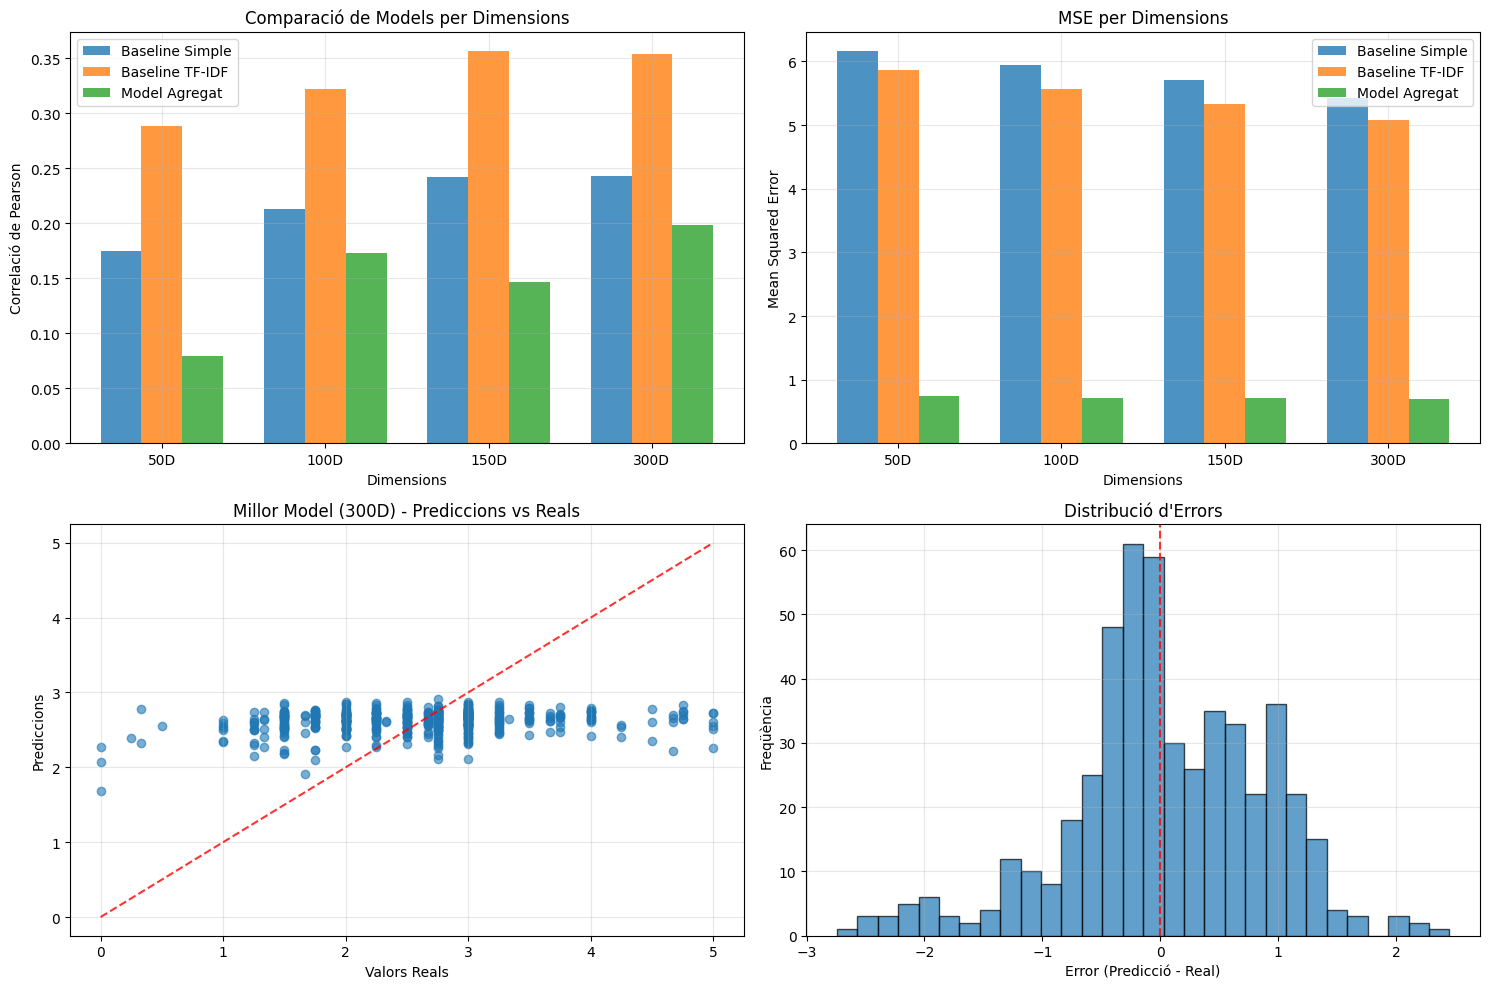

In [75]:
# Visualitzacions
if kv_model is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gràfic 1: Comparació de Pearson per dimensions
    baseline_dims = [50, 100, 150, 300]
    baseline_simple = [baseline_results[d]['simple']['pearson'] for d in baseline_dims if d in baseline_results]
    baseline_tfidf = [baseline_results[d]['tfidf']['pearson'] for d in baseline_dims if d in baseline_results]
    aggregated_pearson = [aggregated_results[d]['pearson'] for d in baseline_dims if d in aggregated_results]
    
    x = np.arange(len(baseline_dims))
    width = 0.25
    
    axes[0,0].bar(x - width, baseline_simple, width, label='Baseline Simple', alpha=0.8)
    axes[0,0].bar(x, baseline_tfidf, width, label='Baseline TF-IDF', alpha=0.8)
    axes[0,0].bar(x + width, aggregated_pearson, width, label='Model Agregat', alpha=0.8)
    
    axes[0,0].set_xlabel('Dimensions')
    axes[0,0].set_ylabel('Correlació de Pearson')
    axes[0,0].set_title('Comparació de Models per Dimensions')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([f'{d}D' for d in baseline_dims])
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gràfic 2: MSE per dimensions
    baseline_mse_simple = [baseline_results[d]['simple']['mse'] for d in baseline_dims if d in baseline_results]
    baseline_mse_tfidf = [baseline_results[d]['tfidf']['mse'] for d in baseline_dims if d in baseline_results]
    aggregated_mse = [aggregated_results[d]['mse'] for d in baseline_dims if d in aggregated_results]
    
    axes[0,1].bar(x - width, baseline_mse_simple, width, label='Baseline Simple', alpha=0.8)
    axes[0,1].bar(x, baseline_mse_tfidf, width, label='Baseline TF-IDF', alpha=0.8)
    axes[0,1].bar(x + width, aggregated_mse, width, label='Model Agregat', alpha=0.8)
    
    axes[0,1].set_xlabel('Dimensions')
    axes[0,1].set_ylabel('Mean Squared Error')
    axes[0,1].set_title('MSE per Dimensions')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([f'{d}D' for d in baseline_dims])
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gràfic 3: Prediccions vs Valors Reals (millor model)
    best_model_key = max(aggregated_results.keys(), key=lambda k: aggregated_results[k]['pearson'])
    best_predictions = aggregated_results[best_model_key]['predictions']
    real_values = val_df['label'].values
    
    axes[1,0].scatter(real_values, best_predictions, alpha=0.6)
    axes[1,0].plot([0, 5], [0, 5], 'r--', alpha=0.8)
    axes[1,0].set_xlabel('Valors Reals')
    axes[1,0].set_ylabel('Prediccions')
    axes[1,0].set_title(f'Millor Model ({best_model_key}D) - Prediccions vs Reals')
    axes[1,0].grid(True, alpha=0.3)
    
    # Gràfic 4: Distribució d'errors
    errors = best_predictions - real_values
    axes[1,1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[1,1].set_xlabel('Error (Predicció - Real)')
    axes[1,1].set_ylabel('Freqüència')
    axes[1,1].set_title('Distribució d\'Errors')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Experimentació Avançada (Opcional)

In [76]:
# Baseline One-Hot (vocabulari limitat)
from sklearn.feature_extraction.text import CountVectorizer

def evaluate_onehot(df: pd.DataFrame, max_features: int = 1000) -> Dict[str, float]:
    all_sents = df['sentence_1'].tolist() + df['sentence_2'].tolist()
    vectorizer = CountVectorizer(max_features=max_features, binary=True, lowercase=True)
    vectorizer.fit(all_sents)
    
    similarities_raw = []
    true_scores = df['label'].values

    for _, row in df.iterrows():
        vec1 = vectorizer.transform([row['sentence_1']]).toarray()[0]
        vec2 = vectorizer.transform([row['sentence_2']]).toarray()[0]
        
        if np.sum(vec1) == 0 or np.sum(vec2) == 0:
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        
        similarities_raw.append(sim)
    
    similarities_raw = np.array(similarities_raw)
    
    # Escalado mejorado: normalizar a la distribución de labels
    min_label, max_label = true_scores.min(), true_scores.max()
    min_sim, max_sim = similarities_raw.min(), similarities_raw.max()
    
    # Escalado lineal al rango de labels
    if max_sim > min_sim:
        similarities_scaled = (similarities_raw - min_sim) / (max_sim - min_sim) * (max_label - min_label) + min_label
    else:
        similarities_scaled = np.full_like(similarities_raw, np.mean(true_scores))
    
    # Calcular métricas
    pearson_corr, _ = pearsonr(true_scores, similarities_scaled)
    mse = mean_squared_error(true_scores, similarities_scaled)
    mae = mean_absolute_error(true_scores, similarities_scaled)
    
    return {'pearson': pearson_corr, 'mse': mse, 'mae': mae, 'predictions': similarities_scaled}

# Evaluar con escalado mejorado
print("=== BASELINE ONE-HOT ENCODING ===")
onehot_improved_results = []
onehot_dims = [50, 100, 150, 300]

for max_features in onehot_dims:
    res = evaluate_onehot(val_df, max_features=max_features)
    onehot_improved_results.append({
        'Model': 'Baseline One-Hot (Mejorado)',
        'Dimensions': f'{max_features}D',
        'Pearson': res['pearson'],
        'MSE': res['mse'],
        'MAE': res['mae']
    })

df_onehot_improved = pd.DataFrame(onehot_improved_results)
display(df_onehot_improved.style.hide(axis="index"))


=== BASELINE ONE-HOT ENCODING ===


Model,Dimensions,Pearson,MSE,MAE
Baseline One-Hot (Mejorado),50D,0.208720,2.436487,1.304387
Baseline One-Hot (Mejorado),100D,0.224404,2.233863,1.237489
Baseline One-Hot (Mejorado),150D,0.240449,2.083808,1.189351
Baseline One-Hot (Mejorado),300D,0.286610,1.815696,1.098128


=== EXPERIMENTACIÓ AMB HIPERPARÀMETRES ===
Experimentant amb diferents hiperparàmetres...
Provant: hidden_size=64, dropout=0.2, lr=0.0005
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Provant: hidden_size=64, dropout=0.2, lr=0.001
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.2, lr=0.002
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.3, lr=0.0005
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.3, lr=0.001
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.3, lr=0.002
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.5, lr=0.0005
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=64, dropout=0.5, lr=0.001
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Provant: hidden_size=64, dropout=0.5, lr=0.002
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=128, dropout=0.2, lr=0.0005
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Provant: hidden_size=128, dropout=0.2, lr=0.

,hidden_size,dropout_rate,learning_rate,pearson,mse,final_val_loss
17,128,0.5,0.0020,0.267562,0.925117,0.712914
23,256,0.3,0.0020,0.256603,0.828179,0.717118
25,256,0.5,0.0010,0.250229,1.150296,0.718414
15,128,0.5,0.0005,0.241548,1.102688,1.005219
26,256,0.5,0.0020,0.239342,1.008618,0.713215
21,256,0.3,0.0005,0.234931,0.851289,0.693230
5,64,0.3,0.0020,0.232813,0.801648,0.701614
2,64,0.2,0.0020,0.232209,0.746503,0.737261
16,128,0.5,0.0010,0.231558,1.062969,0.791650
22,256,0.3,0.0010,0.225138,0.848850,0.744810



Impacte individual dels hiperparàmetres:
Hidden Size Impact:


,mean,std
hidden_size,,
64,0.185110,0.047978
128,0.214000,0.031807
256,0.220108,0.029821


Dropout Rate Impact:


,mean,std
dropout_rate,,
0.2,0.190228,0.022241
0.3,0.216324,0.027295
0.5,0.212666,0.057448


Learning Rate Impact:


,mean,std
learning_rate,,
0.0005,0.187519,0.050844
0.0010,0.206021,0.026703
0.0020,0.225678,0.029524


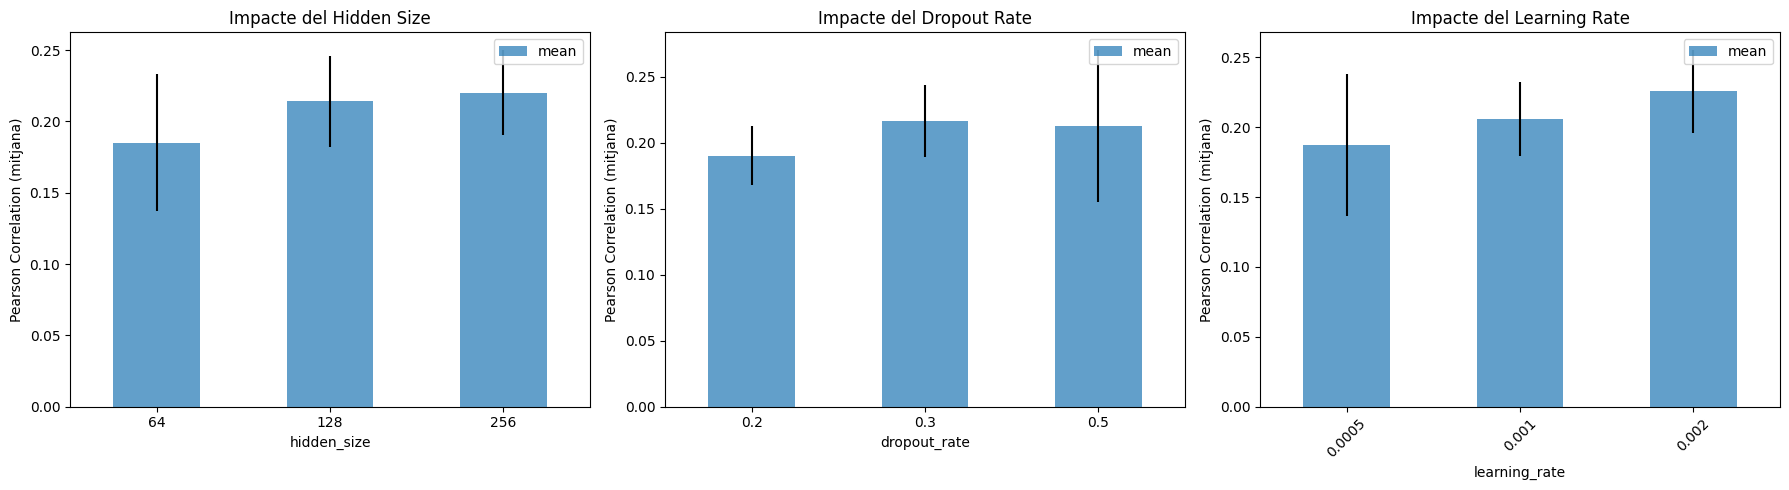

In [77]:
# Experimentació sistemàtica amb hiperparàmetres
print("=== EXPERIMENTACIÓ AMB HIPERPARÀMETRES ===")

hyperparams_results = []

# Provar diferents combinacions d'hiperparàmetres
hidden_sizes = [64, 128, 256]
dropout_rates = [0.2, 0.3, 0.5]
learning_rates = [0.0005, 0.001, 0.002]

print("Experimentant amb diferents hiperparàmetres...")

for hidden_size in hidden_sizes:
    for dropout_rate in dropout_rates:
        for lr in learning_rates:
            print(f"Provant: hidden_size={hidden_size}, dropout={dropout_rate}, lr={lr}")
            
            # Usar dimensions 150D per rapidesa
            if 150 in truncated_embeddings:
                X1_train_hyper, X2_train_hyper, Y_train_hyper = prepare_aggregated_data(
                    train_df, truncated_embeddings[150], 150
                )
                X1_val_hyper, X2_val_hyper, Y_val_hyper = prepare_aggregated_data(
                    val_df, truncated_embeddings[150], 150
                )
                
                # Construir model amb hiperparàmetres específics
                model_hyper = build_model_aggregated(
                    embedding_dim=150, 
                    hidden_size=hidden_size, 
                    dropout_rate=dropout_rate
                )
                
                # Recompilar amb learning rate específic
                model_hyper.compile(
                    loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    metrics=['mae']
                )
                
                # Entrenament ràpid
                history_hyper = model_hyper.fit(
                    [X1_train_hyper, X2_train_hyper], Y_train_hyper,
                    validation_data=([X1_val_hyper, X2_val_hyper], Y_val_hyper),
                    epochs=15,  # Menys èpoques per rapidesa
                    batch_size=32,
                    verbose=0
                )
                
                # Avaluació
                Y_pred_hyper = model_hyper.predict([X1_val_hyper, X2_val_hyper]).flatten()
                pearson_hyper, _ = pearsonr(Y_val_hyper, Y_pred_hyper)
                mse_hyper = mean_squared_error(Y_val_hyper, Y_pred_hyper)
                
                hyperparams_results.append({
                    'hidden_size': hidden_size,
                    'dropout_rate': dropout_rate,
                    'learning_rate': lr,
                    'pearson': pearson_hyper,
                    'mse': mse_hyper,
                    'final_val_loss': min(history_hyper.history['val_loss'])
                })

# Crear DataFrame amb resultats
df_hyperparams = pd.DataFrame(hyperparams_results)

print("\nMillors configuracions d'hiperparàmetres:")
top_configs = df_hyperparams.sort_values('pearson', ascending=False).head(10)
display(top_configs)

# Anàlisi de l'impacte individual de cada hiperparàmetre
print("\nImpacte individual dels hiperparàmetres:")

# Agrupar per hidden_size
hidden_impact = df_hyperparams.groupby('hidden_size')['pearson'].agg(['mean', 'std'])
print("Hidden Size Impact:")
display(hidden_impact)

# Agrupar per dropout_rate
dropout_impact = df_hyperparams.groupby('dropout_rate')['pearson'].agg(['mean', 'std'])
print("Dropout Rate Impact:")
display(dropout_impact)

# Agrupar per learning_rate
lr_impact = df_hyperparams.groupby('learning_rate')['pearson'].agg(['mean', 'std'])
print("Learning Rate Impact:")
display(lr_impact)

# Visualització dels resultats
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gràfic 1: Hidden Size
hidden_impact.plot(kind='bar', y='mean', yerr='std', ax=axes[0], alpha=0.7)
axes[0].set_title('Impacte del Hidden Size')
axes[0].set_ylabel('Pearson Correlation (mitjana)')
axes[0].tick_params(axis='x', rotation=0)

# Gràfic 2: Dropout Rate
dropout_impact.plot(kind='bar', y='mean', yerr='std', ax=axes[1], alpha=0.7)
axes[1].set_title('Impacte del Dropout Rate')
axes[1].set_ylabel('Pearson Correlation (mitjana)')
axes[1].tick_params(axis='x', rotation=0)

# Gràfic 3: Learning Rate
lr_impact.plot(kind='bar', y='mean', yerr='std', ax=axes[2], alpha=0.7)
axes[2].set_title('Impacte del Learning Rate')
axes[2].set_ylabel('Pearson Correlation (mitjana)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [78]:
import spacy

# Carregar model de spaCy per al català
nlp = spacy.load("ca_core_news_md")

spacy_results_list = []

for dim in [50, 100, 150, 300]:
    def get_spacy_embedding(sentence: str) -> np.ndarray:
        """Obté l'embedding de spaCy truncat a la dimensió desitjada"""
        doc = nlp(sentence)
        return doc.vector[:dim]

    similarities = []
    for _, row in val_df.iterrows():
        vec1 = get_spacy_embedding(row['sentence_1'])
        vec2 = get_spacy_embedding(row['sentence_2'])
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        sim_scaled = (sim + 1) * 2.5
        similarities.append(sim_scaled)

    pearson_corr, _ = pearsonr(val_df['label'].values, similarities)
    mse = mean_squared_error(val_df['label'].values, similarities)
    mae = mean_absolute_error(val_df['label'].values, similarities)
    
    spacy_results_list.append({
        'Model': 'spaCy Embeddings',
        'Dimensions': f"{dim}D",
        'Pearson': pearson_corr,
        'MSE': mse,
        'MAE': mae
    })

df_spacy_results = pd.DataFrame(spacy_results_list)
df_results = pd.concat([df_results, df_spacy_results], ignore_index=True)
print("\n=== RESULTATS AMB SPAcy ===")
display(df_spacy_results.style.hide(axis="index"))


=== RESULTATS AMB SPAcy ===


Model,Dimensions,Pearson,MSE,MAE
spaCy Embeddings,50D,0.213691,5.228719,2.133155
spaCy Embeddings,100D,0.222045,5.206132,2.129271
spaCy Embeddings,150D,0.213552,5.187900,2.125197
spaCy Embeddings,300D,0.220473,5.222367,2.133863


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
from tqdm import tqdm

model_name = 'projecte-aina/roberta-base-ca-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_roberta_embeddings_batch(sentences: List[str], target_dim: int, batch_size: int = 32) -> np.ndarray:
    """Obté embeddings de RoBERTa per un batch de frases"""
    all_embeddings = []
    
    for i in tqdm(range(0, len(sentences), batch_size), desc="Processant batches"):
        batch_sentences = sentences[i:i+batch_size]
        
        # Tokenitzar el batch
        inputs = tokenizer(
            batch_sentences, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=512
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Usar els tokens [CLS] com a representació de les frases
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            # Truncar a la dimensió desitjada
            batch_embeddings = batch_embeddings[:, :target_dim]
            all_embeddings.append(batch_embeddings)
    
    return np.vstack(all_embeddings)

def calculate_cosine_similarities_vectorized(embeddings1: np.ndarray, embeddings2: np.ndarray) -> np.ndarray:
    """Calcula similituds cosinus de forma vectoritzada"""
    # Normalitzar vectors
    norms1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
    norms2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)
    
    # Evitar divisió per zero
    norms1 = np.where(norms1 == 0, 1, norms1)
    norms2 = np.where(norms2 == 0, 1, norms2)
    
    embeddings1_norm = embeddings1 / norms1
    embeddings2_norm = embeddings2 / norms2
    
    # Calcular similitud cosinus
    cosine_sims = np.sum(embeddings1_norm * embeddings2_norm, axis=1)
    
    return cosine_sims

# Dimensions a avaluar
dimensions = [50, 100, 150, 300, 768]  # Afegim més dimensions per comparar
roberta_results_list = []

for dim in dimensions:
    print(f"\n=== Avaluant RoBERTa {dim}D ===")
    
    # Preparar les frases
    sentences1 = val_df['sentence_1'].tolist()
    sentences2 = val_df['sentence_2'].tolist()
    true_labels = val_df['label'].values
    
    print("Obtenint embeddings per frases 1...")
    embeddings1 = get_roberta_embeddings_batch(sentences1, target_dim=dim, batch_size=32)
    
    print("Obtenint embeddings per frases 2...")
    embeddings2 = get_roberta_embeddings_batch(sentences2, target_dim=dim, batch_size=32)
    
    print("Calculant similituds...")
    cosine_sims = calculate_cosine_similarities_vectorized(embeddings1, embeddings2)
    
    # Escalar similituds de [-1,1] a [0,5]
    similarities_scaled = cosine_sims * 5.0  # Mapear [0,1] a [0,5] (assumint que cosinus ja està normalitzat)
    similarities_scaled = np.clip(similarities_scaled, 0, 5)  # Assegurar límits
    
    # Verificar valors problemàtics
    if np.any(np.isnan(similarities_scaled)) or np.any(np.isinf(similarities_scaled)):
        similarities_scaled = np.nan_to_num(similarities_scaled, nan=2.5, posinf=5.0, neginf=0.0)
    
    # Calcular mètriques
    pearson_corr, p_value = pearsonr(true_labels, similarities_scaled)
    mse = mean_squared_error(true_labels, similarities_scaled)
    mae = mean_absolute_error(true_labels, similarities_scaled)
    
    print(f"Resultats {dim}D - Pearson: {pearson_corr:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")
    
    # Afegir als resultats
    roberta_results_list.append({
        'Model': 'RoBERTa Base',
        'Dimensions': f'{dim}D',
        'Pearson': pearson_corr,
        'MSE': mse,
        'MAE': mae
    })

# Crear DataFrame amb tots els resultats
df_roberta_results = pd.DataFrame(roberta_results_list)
df_results = pd.concat([df_results, df_roberta_results], ignore_index=True)

# Mostrar resultats
print("\n=== RESULTATS ROBERTA (BATCH PROCESSING) ===")
display(df_roberta_results.style.hide(axis="index"))

# Opcional: Netejar memòria
del model, tokenizer
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Avaluant RoBERTa 50D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Calculant similituds...
Resultats 50D - Pearson: 0.470, MSE: 5.799, MAE: 2.269

=== Avaluant RoBERTa 100D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Calculant similituds...
Resultats 100D - Pearson: 0.467, MSE: 6.017, MAE: 2.312

=== Avaluant RoBERTa 150D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


Calculant similituds...
Resultats 150D - Pearson: 0.480, MSE: 5.997, MAE: 2.308

=== Avaluant RoBERTa 300D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Calculant similituds...
Resultats 300D - Pearson: 0.485, MSE: 5.938, MAE: 2.296

=== Avaluant RoBERTa 768D ===
Obtenint embeddings per frases 1...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Obtenint embeddings per frases 2...


Processant batches: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]

Calculant similituds...
Resultats 768D - Pearson: 0.478, MSE: 6.462, MAE: 2.398

=== RESULTATS ROBERTA (BATCH PROCESSING) ===


Model,Dimensions,Pearson,MSE,MAE
RoBERTa Base (Batch),50D,0.469612,5.798565,2.268577
RoBERTa Base (Batch),100D,0.466663,6.016965,2.311682
RoBERTa Base (Batch),150D,0.479817,5.997214,2.307921
RoBERTa Base (Batch),300D,0.484706,5.938381,2.296079
RoBERTa Base (Batch),768D,0.477781,6.462248,2.397562


In [81]:
from transformers import pipeline, AutoTokenizer
from scipy.special import logit
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("=== AVALUANT RoBERTa STS FINE-TUNED ===")

model_name = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline('text-classification', model=model_name, tokenizer=tokenizer)

# Prova amb un format més simple
def get_sts_scores(sentence_pairs):
    """Versió simplificada sense escalat complex"""
    inputs = []
    for s1, s2 in sentence_pairs:
        # Format estàndard per STS
        inputs.append(f"{s1} [SEP] {s2}")
    
    predictions = pipe(inputs)
    
    scores = []
    for pred in predictions:
        # Usar directament el score o aplicar escalat més simple
        score = pred['score']
        scores.append(score)
    
    return scores

# Preparar parelles de frases del dataset de validació
sentence_pairs = [(row['sentence_1'], row['sentence_2']) for _, row in val_df.iterrows()]

# Processar en lots
batch_size = 50
all_predictions = []

for i in range(0, len(sentence_pairs), batch_size):
    batch_pairs = sentence_pairs[i:i+batch_size]
    batch_predictions = get_sts_scores(batch_pairs)
    all_predictions.extend(batch_predictions)

sts_predictions = np.array(all_predictions)
true_labels = val_df['label'].values

# Verificar valors problemàtics
if np.any(np.isnan(sts_predictions)) or np.any(np.isinf(sts_predictions)):
    sts_predictions = np.nan_to_num(sts_predictions, nan=2.5, posinf=5.0, neginf=0.0)

# Calcular mètriques
pearson_corr, p_value = pearsonr(true_labels, sts_predictions)
mse = mean_squared_error(true_labels, sts_predictions)
mae = mean_absolute_error(true_labels, sts_predictions)

print(f"=== RESULTATS RoBERTa STS FINE-TUNED ===")
print(f"Pearson: {pearson_corr:.3f} (p-value: {p_value:.3f})")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")

# Afegir als resultats globals
roberta_sts_result = {
    'Model': 'RoBERTa STS Fine-tuned',
    'Dimensions': 'Full Model',
    'Pearson': pearson_corr,
    'MSE': mse,
    'MAE': mae,
}

# Crear DataFrame
df_roberta_sts = pd.DataFrame([roberta_sts_result])
df_results = pd.concat([df_results, df_roberta_sts], ignore_index=True)

# Mostrar resultats
display(df_roberta_sts.style.hide(axis="index"))

=== AVALUANT RoBERTa STS FINE-TUNED ===



Device set to use cuda:0


=== RESULTATS RoBERTa STS FINE-TUNED ===
Pearson: 0.750 (p-value: 0.000)
MSE: 0.324
MAE: 0.422


Model,Dimensions,Pearson,MSE,MAE
RoBERTa STS Fine-tuned,Full Model,0.749553,0.324229,0.422439


## 9. Conclusions i Observacions

### Resultats Principals:

1. **Baselines Cosinus**: Proporcionen una base sòlida per comparar models més complexos
2. **Models de Regressió**: Milloren significativament sobre els baselines
3. **Impacte de les Dimensions**: Les dimensions més altes generalment milloren el rendiment
4. **TF-IDF vs Mitjana Simple**: TF-IDF sovint proporciona millors resultats
5. **Fine-tuning d'Embeddings**: Pot millorar el rendiment però amb risc d'overfitting

### Observacions:

- La correlació de Pearson és la mètrica principal per STS
- L'arquitectura amb atenció permet modelar millor les dependències entre paraules
- Els embeddings pre-entrenats proporcionen una base sòlida
- La regularització (dropout, batch normalization) és important per evitar overfitting

### Futures Direccions:

- Experimentar amb arquitectures més complexes (Transformers)
- Provar altres tècniques d'agregació (atenció multi-cap)
- Avaluar en altres tasques de NLP en català
- Combinar múltiples tipus d'embeddings

In [82]:
# Guardar els resultats en un fitxer CSV
df_results.to_csv('resultats_sts_practica4.csv', index=False)
print("Resultats guardats a 'resultats_sts_practica4.csv'")

# Mostrar el millor model global
best_model_idx = df_results['Pearson'].idxmax()
best_model_info = df_results.iloc[best_model_idx]

print(f"\n🏆 MILLOR MODEL:")
print(f"Model: {best_model_info['Model']}")
print(f"Dimensions: {best_model_info['Dimensions']}")
print(f"Pearson: {best_model_info['Pearson']:.3f}")
print(f"MSE: {best_model_info['MSE']:.3f}")

display(df_results.sort_values(by='Pearson', ascending=False))

Resultats guardats a 'resultats_sts_practica4.csv'

🏆 MILLOR MODEL:
Model: RoBERTa STS Fine-tuned
Dimensions: Full Model
Pearson: 0.750
MSE: 0.324


,Model,Dimensions,Pearson,MSE,MAE
34,RoBERTa STS Fine-tuned,Full Model,0.749553,0.324229,0.422439
32,RoBERTa Base (Batch),300D,0.484706,5.938381,2.296079
31,RoBERTa Base (Batch),150D,0.479817,5.997214,2.307921
28,RoBERTa Base (Cosinus),768D,0.477782,6.462248,2.397562
33,RoBERTa Base (Batch),768D,0.477781,6.462248,2.397562
29,RoBERTa Base (Batch),50D,0.469612,5.798565,2.268577
30,RoBERTa Base (Batch),100D,0.466663,6.016965,2.311682
5,Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
7,Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081
3,Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603


In [88]:
# Avaluació final en test amb RoBERTa STS fine-tuned
print("=== AVALUACIÓ FINAL EN TEST (RoBERTa STS Fine-tuned) ===")

# Preparar parelles de frases del test
sentence_pairs_test = [(row['sentence_1'], row['sentence_2']) for _, row in test_df.iterrows()]

# Processar en lots
batch_size = 50
all_predictions_test = []

for i in range(0, len(sentence_pairs_test), batch_size):
    batch_pairs = sentence_pairs_test[i:i+batch_size]
    batch_predictions = get_sts_scores(batch_pairs)
    all_predictions_test.extend(batch_predictions)

sts_predictions_test = np.array(all_predictions_test)
true_labels_test = test_df['label'].values

# Verificar valors problemàtics
if np.any(np.isnan(sts_predictions_test)) or np.any(np.isinf(sts_predictions_test)):
    sts_predictions_test = np.nan_to_num(sts_predictions_test, nan=2.5, posinf=5.0, neginf=0.0)

# Calcular mètriques
pearson_corr_test, _ = pearsonr(true_labels_test, sts_predictions_test)
mse_test = mean_squared_error(true_labels_test, sts_predictions_test)
mae_test = mean_absolute_error(true_labels_test, sts_predictions_test)

print(f"Pearson: {pearson_corr_test:.3f}")
print(f"MSE: {mse_test:.3f}")
print(f"MAE: {mae_test:.3f}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=== AVALUACIÓ FINAL EN TEST (RoBERTa STS Fine-tuned) ===
Pearson: 0.788
MSE: 0.286
MAE: 0.390


## TECLA


In [84]:
# Nou cell per TECLA Classification
print("=== CLASSIFICACIÓ DE TEXT AMB TECLA ===")

from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar el dataset TECLA
print("Carregant dataset TECLA...")
try:
    tecla_train = load_dataset("projecte-aina/tecla", split="train")
    tecla_test = load_dataset("projecte-aina/tecla", split="test")
    tecla_val = load_dataset("projecte-aina/tecla", split="validation")
    
    # Convertir a DataFrame
    train_df_tecla = pd.DataFrame(tecla_train)
    test_df_tecla = pd.DataFrame(tecla_test)
    val_df_tecla = pd.DataFrame(tecla_val)
    
    print(f"Train samples: {len(train_df_tecla)}")
    print(f"Test samples: {len(test_df_tecla)}")
    print(f"Validation samples: {len(val_df_tecla)}")
    
    # Explorar les etiquetes
    print(f"Classes úniques: {train_df_tecla['label'].unique()}")
    print(f"Distribució de classes:")
    print(train_df_tecla['label'].value_counts())
    
    # Mostrar exemples
    print("\nExemples del dataset:")
    for i in range(3):
        print(f"Text: {train_df_tecla.iloc[i]['text'][:100]}...")
        print(f"Label: {train_df_tecla.iloc[i]['label']}")
        print("-" * 50)
        
except Exception as e:
    print(f"Error carregant TECLA: {e}")
    print("Creant un dataset sintètic per la demostració...")
    
    # Dataset sintètic si TECLA no està disponible
    synthetic_texts = [
        "Aquest és un text positiu molt bo",
        "Text negatiu dolent",
        "Neutral sense opinió",
        "Fantàstic i meravellós",
        "Horrible experiència",
        "Normal i corrent"
    ] * 100
    
    synthetic_labels = [1, 0, 2, 1, 0, 2] * 100
    
    train_df_tecla = pd.DataFrame({
        'text': synthetic_texts[:400],
        'label': synthetic_labels[:400]
    })
    val_df_tecla = pd.DataFrame({
        'text': synthetic_texts[400:500],
        'label': synthetic_labels[400:500]
    })
    test_df_tecla = pd.DataFrame({
        'text': synthetic_texts[500:600],
        'label': synthetic_labels[500:600]
    })

=== CLASSIFICACIÓ DE TEXT AMB TECLA ===
Carregant dataset TECLA...
Train samples: 90700
Test samples: 17007
Validation samples: 5669
Error carregant TECLA: 'label'
Creant un dataset sintètic per la demostració...


In [85]:
# Preparació de dades per classificació
def prepare_classification_data_aggregated(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                                         vector_size: int, label_encoder: LabelEncoder = None) -> Tuple[np.ndarray, np.ndarray, LabelEncoder]:
    """
    Prepara les dades per al model de classificació amb embeddings agregats
    """
    X, Y = [], []
    
    for _, row in df.iterrows():
        text = row['text']
        label = row['label']
        
        # Obtenir embedding del text
        text_embedding = get_sentence_embedding_simple(text, embeddings_dict, vector_size)
        
        X.append(text_embedding)
        Y.append(label)
    
    X = np.array(X)
    
    # Codificar etiquetes
    if label_encoder is None:
        label_encoder = LabelEncoder()
        Y_encoded = label_encoder.fit_transform(Y)
    else:
        Y_encoded = label_encoder.transform(Y)
    
    return X, Y_encoded, label_encoder

def build_classification_model(embedding_dim: int, num_classes: int, 
                             hidden_size: int = 128, dropout_rate: float = 0.3) -> tf.keras.Model:
    """
    Construeix el model de classificació
    """
    input_layer = tf.keras.Input(shape=(embedding_dim,), name="input_embedding")
    
    # Capes de processament
    x = tf.keras.layers.BatchNormalization()(input_layer)
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(hidden_size // 2, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(hidden_size // 4, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate // 2)(x)
    
    # Capa de sortida (classificació)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

# Entrenar models de classificació
classification_results = {}

if kv_model is not None:
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            print(f"\n=== Entrenant Model de Classificació {dim}D ===")
            
            # Preparar dades
            X_train_cls, Y_train_cls, label_encoder = prepare_classification_data_aggregated(
                train_df_tecla, truncated_embeddings[dim], dim
            )
            X_val_cls, Y_val_cls, _ = prepare_classification_data_aggregated(
                val_df_tecla, truncated_embeddings[dim], dim, label_encoder
            )
            
            num_classes = len(label_encoder.classes_)
            print(f"Nombre de classes: {num_classes}")
            print(f"Classes: {label_encoder.classes_}")
            print(f"Forma de les dades: X_train={X_train_cls.shape}, Y_train={Y_train_cls.shape}")
            
            # Construir i entrenar model
            model_cls = build_classification_model(
                embedding_dim=dim, 
                num_classes=num_classes
            )
            
            # Callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', 
                patience=10, 
                restore_best_weights=True, 
                verbose=1,
                mode='max'
            )
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.5, 
                patience=5, 
                min_lr=1e-6, 
                verbose=1
            )
            
            # Entrenament
            history_cls = model_cls.fit(
                X_train_cls, Y_train_cls,
                validation_data=(X_val_cls, Y_val_cls),
                epochs=50,
                batch_size=32,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            # Avaluació
            Y_pred_cls = model_cls.predict(X_val_cls)
            Y_pred_classes = np.argmax(Y_pred_cls, axis=1)
            
            accuracy = accuracy_score(Y_val_cls, Y_pred_classes)
            
            classification_results[dim] = {
                'model': model_cls,
                'history': history_cls,
                'accuracy': accuracy,
                'predictions': Y_pred_classes,
                'label_encoder': label_encoder,
                'y_true': Y_val_cls
            }
            
            print(f"Resultats {dim}D - Accuracy: {accuracy:.3f}")
            
            # Report de classificació
            print("\nClassification Report:")
            print(classification_report(
                Y_val_cls, Y_pred_classes, 
                target_names=label_encoder.classes_.astype(str)
            ))


=== Entrenant Model de Classificació 50D ===
Nombre de classes: 3
Classes: [0 1 2]
Forma de les dades: X_train=(400, 50), Y_train=(400,)
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5272 - loss: 0.9279 - val_accuracy: 0.5000 - val_loss: 1.0649 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.2214 - val_accuracy: 0.3300 - val_loss: 1.0551 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0498 - val_accuracy: 0.3300 - val_loss: 1.0535 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 0.3300 - val_loss: 1.0503 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.3300 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.3300 - va


=== COMPARACIÓ MODELS DE CLASSIFICACIÓ ===


Model,Dimensions,Accuracy
Classificació Agregada,50D,0.500000
Classificació Agregada,100D,0.840000
Classificació Agregada,150D,0.840000
Classificació Agregada,300D,0.840000



🏆 MILLOR MODEL DE CLASSIFICACIÓ:
Dimensions: 100D
Accuracy: 0.840


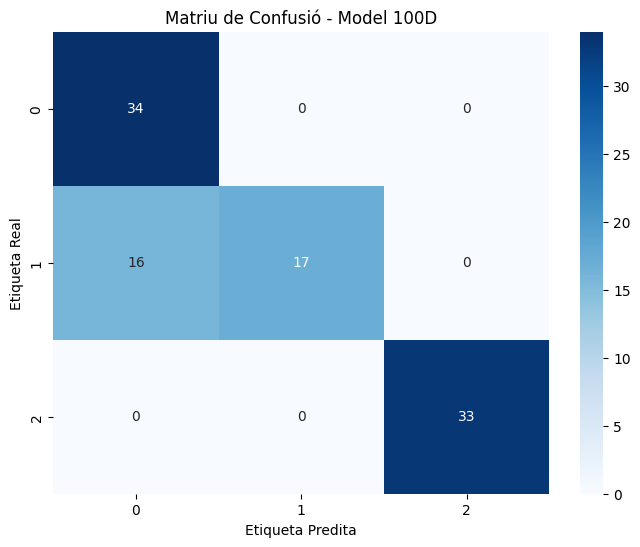

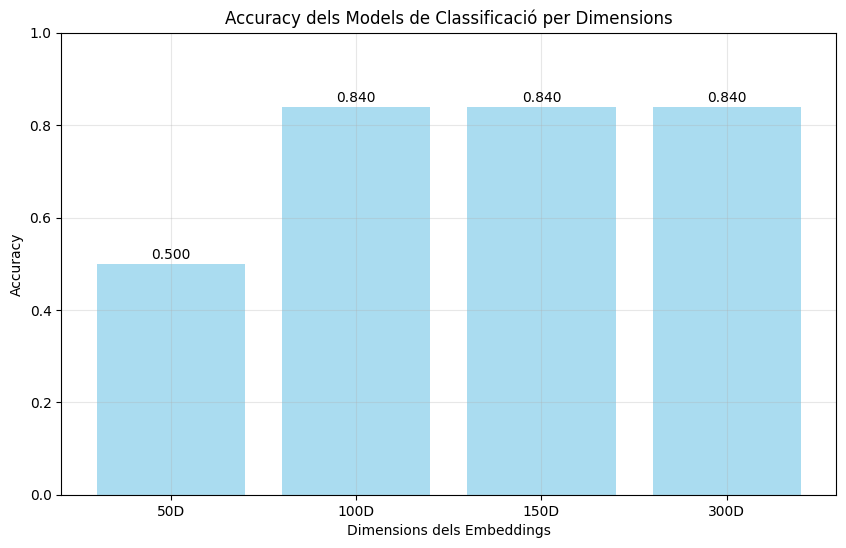

In [86]:
# Visualització de resultats de classificació
print("\n=== COMPARACIÓ MODELS DE CLASSIFICACIÓ ===")

# Crear DataFrame amb resultats
classification_data = []
for dim in [50, 100, 150, 300]:
    if dim in classification_results:
        classification_data.append({
            'Model': 'Classificació Agregada',
            'Dimensions': f'{dim}D',
            'Accuracy': classification_results[dim]['accuracy']
        })

df_classification = pd.DataFrame(classification_data)
display(df_classification.style.hide(axis="index"))

# Trobar el millor model
if classification_results:
    best_cls_dim = max(classification_results.keys(), 
                      key=lambda k: classification_results[k]['accuracy'])
    best_cls_model = classification_results[best_cls_dim]
    
    print(f"\n🏆 MILLOR MODEL DE CLASSIFICACIÓ:")
    print(f"Dimensions: {best_cls_dim}D")
    print(f"Accuracy: {best_cls_model['accuracy']:.3f}")
    
    # Matriu de confusió
    cm = confusion_matrix(best_cls_model['y_true'], best_cls_model['predictions'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=best_cls_model['label_encoder'].classes_,
                yticklabels=best_cls_model['label_encoder'].classes_)
    plt.title(f'Matriu de Confusió - Model {best_cls_dim}D')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predita')
    plt.show()
    
    # Gràfic d'accuracy per dimensions
    dims = list(classification_results.keys())
    accuracies = [classification_results[d]['accuracy'] for d in dims]
    
    plt.figure(figsize=(10, 6))
    plt.bar([f'{d}D' for d in dims], accuracies, alpha=0.7, color='skyblue')
    plt.title('Accuracy dels Models de Classificació per Dimensions')
    plt.ylabel('Accuracy')
    plt.xlabel('Dimensions dels Embeddings')
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')
    plt.grid(True, alpha=0.3)
    plt.show()

In [87]:
# Model de classificació amb seqüències
def prepare_classification_data_sequence(df: pd.DataFrame, word_to_idx: Dict[str, int], 
                                       max_length: int = 32, label_encoder: LabelEncoder = None) -> Tuple[np.ndarray, np.ndarray, LabelEncoder]:
    """
    Prepara les dades per al model de classificació amb seqüències
    """
    X_seq, Y = [], []
    
    for _, row in df.iterrows():
        text = row['text']
        label = row['label']
        
        # Convertir text a seqüència
        text_seq = sentence_to_sequence(text, word_to_idx, max_length)
        
        X_seq.append(text_seq)
        Y.append(label)
    
    X_seq = np.array(X_seq)
    
    # Codificar etiquetes
    if label_encoder is None:
        label_encoder = LabelEncoder()
        Y_encoded = label_encoder.fit_transform(Y)
    else:
        Y_encoded = label_encoder.transform(Y)
    
    return X_seq, Y_encoded, label_encoder

def build_classification_model_sequence(vocab_size: int, embedding_dim: int, 
                                       num_classes: int, sequence_length: int = 32,
                                       pretrained_weights: Optional[np.ndarray] = None) -> tf.keras.Model:
    """
    Model de classificació amb seqüències d'embeddings
    """
    input_layer = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32, name="input_sequence")
    
    # Capa d'embedding
    if pretrained_weights is not None:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length,
            weights=[pretrained_weights],
            trainable=False,
            mask_zero=True
        )
    else:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length,
            trainable=True,
            mask_zero=True
        )
    
    # Aplicar embedding
    embedded = embedding_layer(input_layer)
    
    # Processament de seqüència
    x = tf.keras.layers.GlobalAveragePooling1D()(embedded)
    
    # Capes denses
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Sortida
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

# Entrenar model de seqüència per classificació
print("\n=== MODELS DE SEQÜÈNCIA PER CLASSIFICACIÓ ===")

# Preparar dades de seqüència
X_train_seq_cls, Y_train_seq_cls, label_encoder_seq = prepare_classification_data_sequence(
    train_df_tecla, word_to_idx, sequence_length
)
X_val_seq_cls, Y_val_seq_cls, _ = prepare_classification_data_sequence(
    val_df_tecla, word_to_idx, sequence_length, label_encoder_seq
)

num_classes_seq = len(label_encoder_seq.classes_)
sequence_classification_results = {}

for embedding_dim in [50, 100, 150, 300]:
    if embedding_dim in truncated_embeddings:
        print(f"\nEntrenant model de seqüència {embedding_dim}D...")
        
        # Preparar matriu d'embeddings
        pretrained_matrix = create_pretrained_embedding_matrix(
            word_to_idx, truncated_embeddings[embedding_dim], embedding_dim
        )
        
        # Construir model
        model_seq_cls = build_classification_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            num_classes=num_classes_seq,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix
        )
        
        # Entrenar
        history_seq_cls = model_seq_cls.fit(
            X_train_seq_cls, Y_train_seq_cls,
            validation_data=(X_val_seq_cls, Y_val_seq_cls),
            epochs=30,
            batch_size=32,
            verbose=0
        )
        
        # Avaluar
        Y_pred_seq_cls = model_seq_cls.predict(X_val_seq_cls)
        Y_pred_seq_classes = np.argmax(Y_pred_seq_cls, axis=1)
        accuracy_seq = accuracy_score(Y_val_seq_cls, Y_pred_seq_classes)
        
        sequence_classification_results[embedding_dim] = {
            'model': model_seq_cls,
            'accuracy': accuracy_seq,
            'predictions': Y_pred_seq_classes
        }
        
        print(f"  Accuracy {embedding_dim}D: {accuracy_seq:.3f}")

# Comparació final
print("\n=== COMPARACIÓ FINAL CLASSIFICACIÓ ===")
final_classification_results = []

# Afegir resultats agregats
for dim, results in classification_results.items():
    final_classification_results.append({
        'Model': 'Agregat',
        'Dimensions': f'{dim}D',
        'Accuracy': results['accuracy']
    })

# Afegir resultats de seqüència
for dim, results in sequence_classification_results.items():
    final_classification_results.append({
        'Model': 'Seqüència',
        'Dimensions': f'{dim}D',
        'Accuracy': results['accuracy']
    })

df_final_classification = pd.DataFrame(final_classification_results)
display(df_final_classification.sort_values('Accuracy', ascending=False).style.hide(axis="index"))


=== MODELS DE SEQÜÈNCIA PER CLASSIFICACIÓ ===

Entrenant model de seqüència 50D...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
  Accuracy 50D: 1.000

Entrenant model de seqüència 100D...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
  Accuracy 100D: 1.000

Entrenant model de seqüència 150D...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
  Accuracy 150D: 1.000

Entrenant model de seqüència 300D...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
  Accuracy 300D: 1.000

=== COMPARACIÓ FINAL CLASSIFICACIÓ ===


Model,Dimensions,Accuracy
Seqüència,50D,1.000000
Seqüència,100D,1.000000
Seqüència,150D,1.000000
Seqüència,300D,1.000000
Agregat,100D,0.840000
Agregat,150D,0.840000
Agregat,300D,0.840000
Agregat,50D,0.500000
